# CNN Clássica

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
# import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import random
import os

In [23]:
dataset = 2 # 1 para dataset e 2 para Retinal Fundus Image

if dataset == 1:
    path = 'Datasets/dataset processed'
    data_dir = pathlib.Path(path)
    print(len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.png')) + list(data_dir.glob('*/*.jpeg'))))
    subfolders = [f.name for f in data_dir.iterdir() if f.is_dir()]
elif dataset == 2:
    path_train = 'Datasets/Retinal Fundus Images processed/train'
    data_dir_train = pathlib.Path(path_train)
    path_test = 'Datasets/Retinal Fundus Images processed/test'
    data_dir_test = pathlib.Path(path_test)
    path_val = 'Datasets/Retinal Fundus Images processed/val'
    data_dir_val = pathlib.Path(path_val)

    subfolders = [f.name for f in data_dir_train.iterdir() if f.is_dir()]

    print(f"train: {len(list(data_dir_train.glob('*/*.jpg')) + list(data_dir_train.glob('*/*.png')) + list(data_dir_train.glob('*/*.jpeg')))}")
    print(f"test: {len(list(data_dir_test.glob('*/*.jpg')) + list(data_dir_test.glob('*/*.png')) + list(data_dir_test.glob('*/*.jpeg')))}")
    print(f"val: {len(list(data_dir_val.glob('*/*.jpg')) + list(data_dir_val.glob('*/*.png')) + list(data_dir_val.glob('*/*.jpeg')))}")


train: 20077
test: 1236
val: 433


In [24]:
subfolders

['1.Dry AMD',
 '10.Glaucoma',
 '11.Normal Fundus',
 '2.Wet AMD',
 '3.Mild DR',
 '4.Moderate DR',
 '5.Severe DR',
 '6.Proliferate DR',
 '7.Cataract',
 '8.Hypertensive Retinopathy',
 '9.Pathological Myopia']

In [25]:
if dataset == 1:
    for subfolder in subfolders:
        path = data_dir / subfolder
        images = list(path.glob('*.jpg')) + list(path.glob('*.jpeg')) + list(path.glob('*.png'))
        print(f'Classe {subfolder} tem {len(images)} imagens.')

        if images:
            img = Image.open(str(images[0]))
            img_array = np.array(img)

            print(f'Dimensões da primeira imagem em {subfolder}: {img_array.shape}')
elif dataset == 2:
    for subfolder in subfolders:
        path = data_dir_train / subfolder
        images = list(path.glob('*.jpg')) + list(path.glob('*.jpeg')) + list(path.glob('*.png'))
        print(f'Classe {subfolder} tem {len(images)} imagens.')

        if images:
            img = Image.open(str(images[0]))
            img_array = np.array(img)

            print(f'Dimensões da primeira imagem em {subfolder}: {img_array.shape}')

Classe 1.Dry AMD tem 1276 imagens.
Dimensões da primeira imagem em 1.Dry AMD: (224, 224, 3)
Classe 10.Glaucoma tem 1678 imagens.
Dimensões da primeira imagem em 10.Glaucoma: (224, 224, 3)
Classe 11.Normal Fundus tem 2641 imagens.
Dimensões da primeira imagem em 11.Normal Fundus: (224, 224, 3)
Classe 2.Wet AMD tem 545 imagens.
Dimensões da primeira imagem em 2.Wet AMD: (224, 224, 3)
Classe 3.Mild DR tem 2294 imagens.
Dimensões da primeira imagem em 3.Mild DR: (224, 224, 3)
Classe 4.Moderate DR tem 4982 imagens.
Dimensões da primeira imagem em 4.Moderate DR: (224, 224, 3)
Classe 5.Severe DR tem 1635 imagens.
Dimensões da primeira imagem em 5.Severe DR: (224, 224, 3)
Classe 6.Proliferate DR tem 1295 imagens.
Dimensões da primeira imagem em 6.Proliferate DR: (224, 224, 3)
Classe 7.Cataract tem 1369 imagens.
Dimensões da primeira imagem em 7.Cataract: (224, 224, 3)
Classe 8.Hypertensive Retinopathy tem 1220 imagens.
Dimensões da primeira imagem em 8.Hypertensive Retinopathy: (224, 224, 3)
C

In [26]:
batch_size = 16

In [27]:
if dataset == 1:
    treino = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        batch_size=batch_size,
        image_size=(224, 224)
    )

    validacao = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        batch_size=batch_size,
        image_size=(224, 224)
    )

elif dataset == 2:
    treino = tf.keras.utils.image_dataset_from_directory(
        data_dir_train,
        seed=42,
        batch_size=batch_size,
        image_size=(224, 224)
    )

    validacao = tf.keras.utils.image_dataset_from_directory(
        data_dir_val,
        seed=42,
        batch_size=batch_size,
        image_size=(224, 224)
    )

    teste = tf.keras.utils.image_dataset_from_directory(
        data_dir_test,
        seed=42,
        image_size=(224, 224),
        batch_size=batch_size,
    )

Found 20077 files belonging to 11 classes.
Found 433 files belonging to 11 classes.
Found 1236 files belonging to 11 classes.


In [28]:
print(treino.class_names)
tf.random.set_seed(42)

altura, largura = (224, 224)

['1.Dry AMD', '10.Glaucoma', '11.Normal Fundus', '2.Wet AMD', '3.Mild DR', '4.Moderate DR', '5.Severe DR', '6.Proliferate DR', '7.Cataract', '8.Hypertensive Retinopathy', '9.Pathological Myopia']


In [29]:
if dataset == 1:
    seeds = [42, 123, 3824, 321, 5643]
    epocas = 50
    n_rodadas = 5

    resultados = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrix': []
    }

    y_true = []
    x_val_list = []

    for images, labels in validacao:
        x_val_list.append(images.numpy())
        y_true.extend(labels.numpy())

    x_val = np.concatenate(x_val_list)
    y_true = np.array(y_true)
    print("Dados carregados.")

    for i in range(n_rodadas):
        print(f"\n--- Rodada {i+1}/{n_rodadas} (Seed: {seeds[i]}) ---")
        seed = seeds[i]
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

        modelo = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape = (altura, largura, 3)),

            tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

        modelo.compile(
            optimizer = tf.keras.optimizers.Adam(1e-3),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy']
        )

        modelo.summary()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        history = modelo.fit(
            treino,
            validation_data = validacao,
            epochs = epocas,
            callbacks = [early_stopping]
        )

        y_pred_probs = modelo.predict(x_val, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_true, y_pred)
        
        resultados['accuracy'].append(acc)
        resultados['precision'].append(prec)
        resultados['recall'].append(rec)
        resultados['f1'].append(f1)
        resultados['confusion_matrix'].append(cm)
        
        print(f"Resultado Rodada {i+1}: Acc: {acc:.4f} | F1: {f1:.4f}")



    def formatar_media_desvio(lista_valores):
        media = np.mean(lista_valores) * 100
        desvio = np.std(lista_valores) * 100
        return f"{media:.2f} ± {desvio:.2f} %"

    print("\n" + "="*40)
    print("RELATÓRIO FINAL (Média de 5 rodadas)")
    print("="*40)
    print(f"Accuracy:  {formatar_media_desvio(resultados['accuracy'])}")
    print(f"Precision: {formatar_media_desvio(resultados['precision'])}")
    print(f"Recall:    {formatar_media_desvio(resultados['recall'])}")
    print(f"F1-Score:  {formatar_media_desvio(resultados['f1'])}")

elif dataset == 2:
    seeds = [42, 123, 321, 5643, 142]
    epocas = 50
    n_rodadas = 5

    resultados = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrix': []
    }

    y_true = []
    x_test_list = []

    for images, labels in teste:
        x_test_list.append(images.numpy())
        y_true.extend(labels.numpy())

    x_test = np.concatenate(x_test_list)
    y_true = np.array(y_true)
    print("Dados carregados.")

    for i in range(n_rodadas):
        print(f"\n--- Rodada {i+1}/{n_rodadas} (Seed: {seeds[i]}) ---")
        seed = seeds[i]
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

        modelo = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape = (altura, largura, 3)),

            tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.GlobalAveragePooling2D(),

            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(11, activation = 'softmax')
        ])

        modelo.compile(
            optimizer = tf.keras.optimizers.Adam(1e-3),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy']
        )

        modelo.summary()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        history = modelo.fit(
            treino,
            validation_data = validacao,
            epochs = epocas,
            callbacks = [early_stopping]
        )

        y_pred_probs = modelo.predict(x_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1) 
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        resultados['accuracy'].append(acc)
        resultados['precision'].append(prec)
        resultados['recall'].append(rec)
        resultados['f1'].append(f1)
        resultados['confusion_matrix'].append(cm)
        
        print(f"Resultado Rodada {i+1}: Acc: {acc:.4f} | F1: {f1:.4f}")



    def formatar_media_desvio(lista_valores):
        media = np.mean(lista_valores) * 100
        desvio = np.std(lista_valores) * 100
        return f"{media:.2f} ± {desvio:.2f} %"

    print("\n" + "="*40)
    print("RELATÓRIO FINAL (Média de 5 rodadas)")
    print("="*40)
    print(f"Accuracy:  {formatar_media_desvio(resultados['accuracy'])}")
    print(f"Precision: {formatar_media_desvio(resultados['precision'])}")
    print(f"Recall:    {formatar_media_desvio(resultados['recall'])}")
    print(f"F1-Score:  {formatar_media_desvio(resultados['f1'])}")

Dados carregados.

--- Rodada 1/5 (Seed: 42) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,315 (9.04 KB)

 Trainable params: 2,315 (9.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
  82/1255 ━━━━━━━━━━━━━━━━━━━━ 1:11 61ms/step - accuracy: 0.1914 - loss: 5.1943

KeyboardInterrupt: 


Matriz de Confusão Média:
[[ 26.    2.6   7.2   0.    0.    0.    0.8   1.4   4.   11.6   0.4]
 [ 12.6  86.    6.    4.2   0.    1.4   0.    6.   29.2   7.4   3.2]
 [  1.4   2.  169.6   0.    0.    1.6   1.2   0.4   0.    2.4   0.4]
 [  5.6   8.2   0.    0.2   0.    0.    0.    0.    2.6   6.4   0. ]
 [  0.    0.    0.6   0.   23.   74.8   2.4   1.2   0.    0.    0. ]
 [  0.    0.    0.    0.   15.8 189.6   5.6   5.    0.    0.    0. ]
 [  1.    1.2   0.2   0.4   1.2  24.6  66.   12.2   0.2   0.    0. ]
 [  1.    0.    1.4   0.2   0.   19.8  47.8  20.8   0.    0.    0. ]
 [  3.    7.6   0.    0.    0.    0.    0.    0.  100.6   0.8   0. ]
 [ 23.6  18.8   8.    0.2   0.    0.    1.2   0.    2.   36.2   4. ]
 [ 10.8  18.6   4.2   1.    0.    0.    0.    0.    0.    1.6  65.8]]


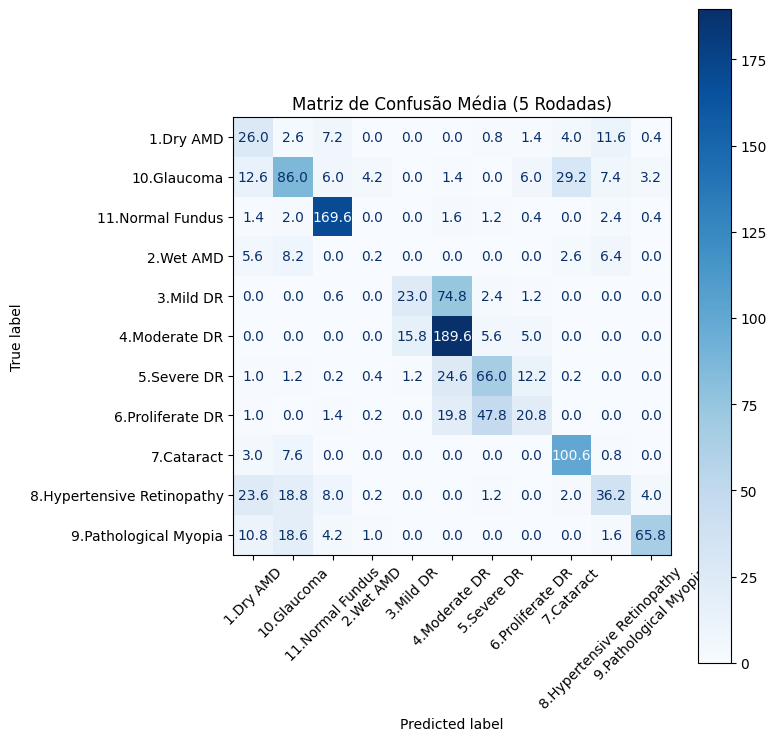

In [ ]:
print("\nMatriz de Confusão Média:")

cm_media = np.mean(resultados['confusion_matrix'], axis=0)
print(np.round(cm_media, 1))

class_names = ['1.Dry AMD', '10.Glaucoma', '11.Normal Fundus', '2.Wet AMD', '3.Mild DR', '4.Moderate DR', '5.Severe DR', '6.Proliferate DR', '7.Cataract', '8.Hypertensive Retinopathy', '9.Pathological Myopia']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_media, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='.1f')

plt.title("Matriz de Confusão Média (5 Rodadas)")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

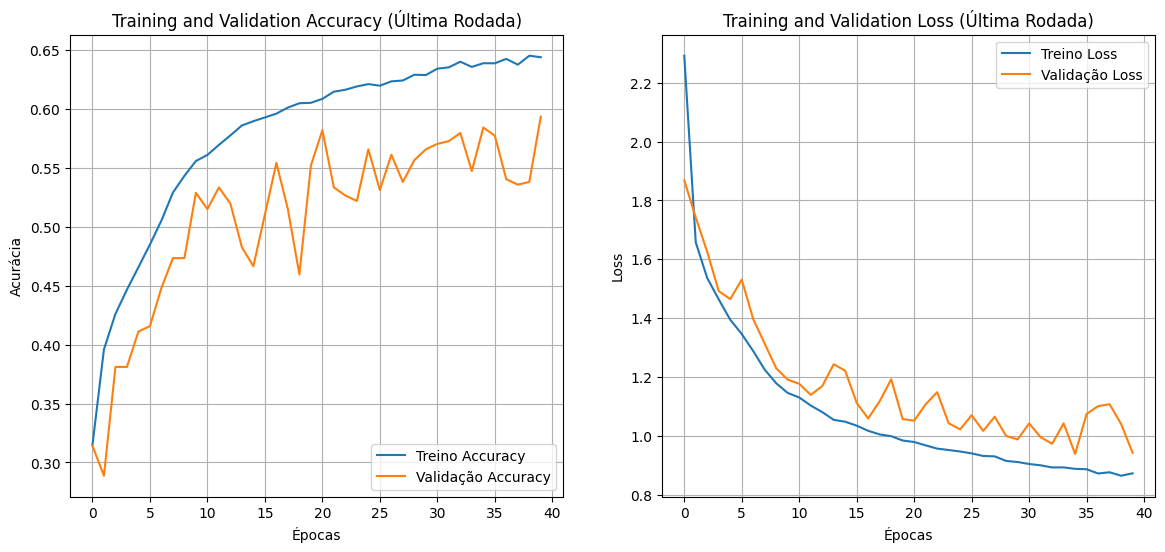

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino Accuracy')
plt.plot(epochs_range, val_acc, label='Validação Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Última Rodada)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino Loss')
plt.plot(epochs_range, val_loss, label='Validação Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Última Rodada)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True)

plt.show()